In [ ]:
from torchvision.models import resnet18, GoogLeNet, list_models, get_model
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Compose
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss

In [ ]:
transform1 = Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5), std=(0.5))])

batch_size = 32
num_classes = 10

train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform1)
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform1)

train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100825533.57it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 121135693.82it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27026180.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20440481.51it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class VGG11(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG11, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        # convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # fully connected linear layers
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(in_features=4096, out_features=self.num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        train_losses.append(loss.data)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('\rEpoch: {} {:.0f}%\t     Loss: {:.6f}'.format(
                epoch,
                100. * batch_idx / len(train_loader), loss.data), end='')

In [ ]:
def test():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).data
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()


    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    acc=100. * float(correct.to(torch.device('cpu')).numpy())
    print('\nTest result: Average loss: {:.4f}, Accuracy: {:.4f}%\n'.format(
        test_loss, acc / len(test_loader.dataset)))

    test_accuracy.append(acc / len(test_loader.dataset))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 96%	     Loss: 2.299290

<ipython-input-7-ab0e57baa3de>:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test result: Average loss: 2.3011, Accuracy: 11.3500%

Epoch: 2 96%	     Loss: 2.294050
Test result: Average loss: 2.3009, Accuracy: 11.3500%

Epoch: 3 96%	     Loss: 2.291682
Test result: Average loss: 2.3005, Accuracy: 11.3500%

Epoch: 4 96%	     Loss: 1.302782
Test result: Average loss: 0.5962, Accuracy: 80.9000%

Epoch: 5 96%	     Loss: 0.053026
Test result: Average loss: 0.0517, Accuracy: 98.2700%

Epoch: 6 96%	     Loss: 0.214513
Test result: Average loss: 0.0414, Accuracy: 98.7700%

Epoch: 7 96%	     Loss: 0.003033
Test result: Average loss: 0.0392, Accuracy: 98.7500%

Epoch: 8 96%	     Loss: 0.000870
Test result: Average loss: 0.0269, Accuracy: 99.0300%

Epoch: 9 96%	     Loss: 0.002975
Test result: Average loss: 0.0276, Accuracy: 99.1400%

Epoch: 10 96%	     Loss: 0.000711
Test result: Average loss: 0.0295, Accuracy: 98.9500%

Epoch: 11 96%	     Loss: 0.005362
Test result: Average loss: 0.0275, Accuracy: 99.1900%

Epoch: 12 96%	     Loss: 0.000008
Test result: Average loss: 0

TypeError: ignored

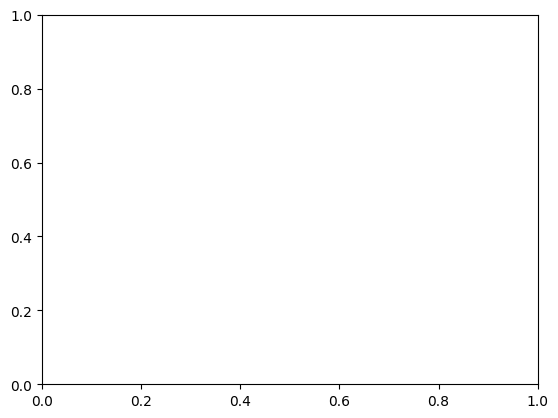

In [ ]:
model = VGG11(in_channels = 1, num_classes = num_classes)
if torch.cuda.is_available():
    model.cuda()

optimizer = optim.SGD(model.parameters(), lr=0.01)


train_losses = []
test_losses =[]
test_accuracy = []
for epoch in range(1, 15):
    train(epoch)
    test()

# Functions graphed when not using GPU
plt.figure()
plt.plot(train_losses)
plt.title('train losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_losses)
plt.title('test losses')
plt.xlabel('step')
plt.ylabel('percent')

plt.figure()
plt.plot(test_accuracy)
plt.title('test_accuracy')
plt.xlabel('step')
plt.ylabel('percent')

In [ ]:
# 1:44:5
torch.save(model.state_dict(), './VGG11Model')

In [ ]:
model = VGG11(in_channels = 1, num_classes = num_classes)
model.load_state_dict(torch.load('/content/VGG11Model'))
model.eval()

VGG11(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = img.unsqueeze(0)
    prediction =  model(img)
    softmaxEl = F.softmax(prediction, dim=1)
    pred = softmaxEl.max()
    copy = softmaxEl
    copy = copy.cpu().detach().numpy()
    # copy is in the form of [[1 2 3 ... 10]]
    new = copy[0]
    # new is in the form of [1 2 3 ... 10]
    outputs_arr.append(new)
    # allows use of log_loss function
    predLab = np.argmax(copy)
    pred_label[i] = predLab
    pred_labelscore[i] = pred
    _, preds = torch.max(prediction, dim = 1)
    return 'Done'

In [ ]:
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=1,shuffle=False)

outputs_arr = []
pred_label = np.zeros(len(test_loader))
pred_labelscore = np.zeros(len(test_loader))
true_label = np.zeros(len(test_loader))
i = 0
model.eval()
for data, target in test_loader:
  predict_img_class(data[0], model)
  true_label[i] = target
  i = i+1

print(log_loss(true_label,outputs_arr))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


0.032775170670152426


In [ ]:
#46:12 w/ GPU

newdf = np.zeros((len(test_loader),3))
for j in range(len(test_loader)):
  newdf[j][0] = true_label[j]
  newdf[j][1] = pred_label[j]
  newdf[j][2] = pred_labelscore[j]
df = pd.DataFrame(newdf)
df.to_excel('VGG11ExcelML.xlsx')